Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


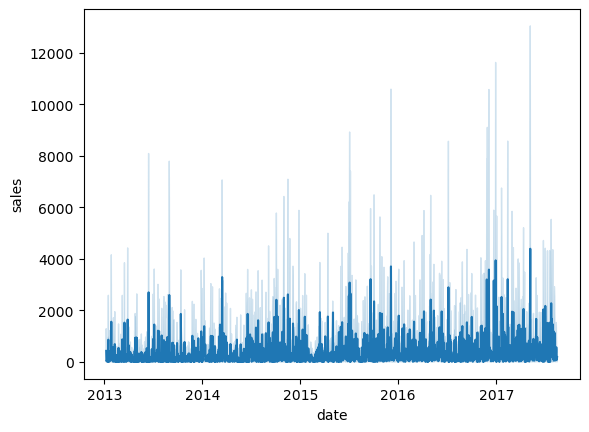

RSME: 464.21


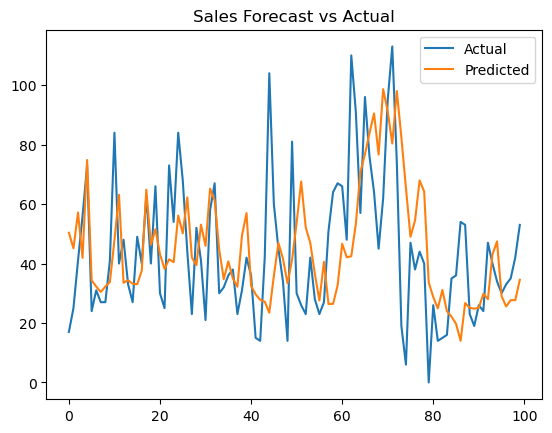

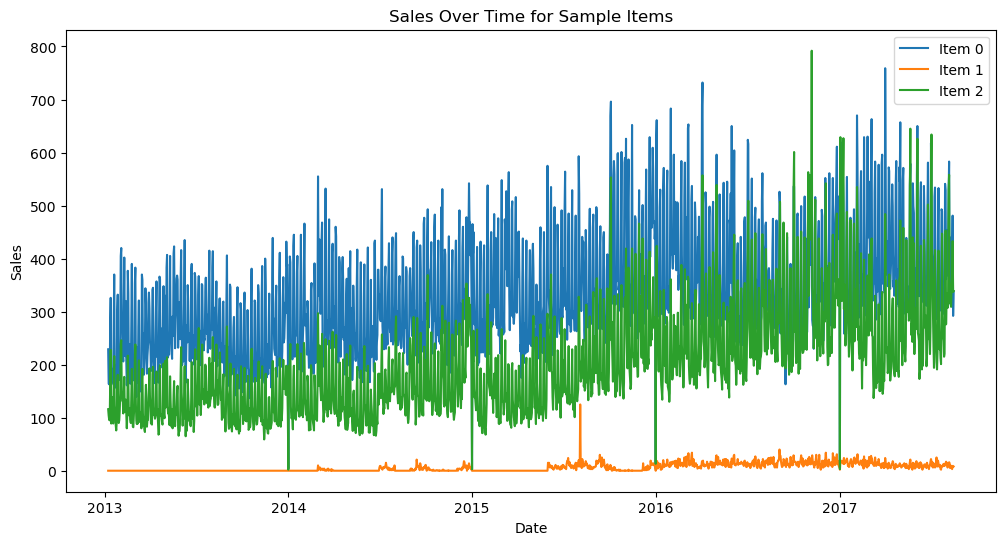

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('train.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv',parse_dates=['date'])

print(train.columns)

#np.random.seed(42)
#train['item_nbr'] = np.random.randint(1000, 1100, size=len(train)) 

train = train.merge(stores,on='store_nbr',how='left')
train = train.merge(oil,on='date',how='left')
train['day']=train['date'].dt.day
train['month']=train['date'].dt.month
train['year']=train['date'].dt.year
train['dayofweek']=train['date'].dt.dayofweek
train['is_weekend']=train['dayofweek'].isin([5,6]).astype(int)


le_item = LabelEncoder()
train['item_nbr'] = le_item.fit_transform(train['family'])

le_store= LabelEncoder()
train['store_nbr'] = le_store.fit_transform(train['store_nbr'])

train['onpromotion'] = train['onpromotion'].fillna(0).astype(int)

train = train.sort_values(['store_nbr', 'item_nbr', 'date'])
train['sales_lag_7'] = train.groupby(['store_nbr', 'item_nbr'])['sales'].shift(7)
train['sales_rolling_mean_7'] = train.groupby(['store_nbr', 'item_nbr'])['sales'].transform(lambda x: x.shift(1).rolling(window=7).mean())
train = train.dropna(subset=['sales_lag_7', 'sales_rolling_mean_7'])
train.drop('type', axis=1, inplace=True)

sns.lineplot(x='date',y='sales',data=train.sample(10000))
plt.show()

X= train[['store_nbr','item_nbr','day','month','year','dayofweek','is_weekend','onpromotion', 'sales_lag_7', 'sales_rolling_mean_7']]
y=train['sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RSME:",round(rmse,2))

plt.plot(y_val.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.title('Sales Forecast vs Actual')
plt.show()


sample_items = train['item_nbr'].unique()[:3]  

plt.figure(figsize=(12, 6))
for item in sample_items:
    item_data = train[train['item_nbr'] == item]
    daily_sales = item_data.groupby('date')['sales'].sum()
    plt.plot(daily_sales.index, daily_sales.values, label=f'Item {item}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time for Sample Items')
plt.legend()
plt.show()

In [2]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/29/22/e3ff2dfafe862a91733dfa0aecdb4794aa1d9a18e09a14e118bde0cbc2db/xgboost-3.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB 4.5 MB/s eta 0:00:34
   ---------------------------------------- 0.7/150.0 MB 6.3 MB/s eta 0:00:24
   ---------------------------------------- 1.1/150.0 MB 7.0 MB/s eta 0:00:22
   ---------------------------------------- 1.6/150.0 MB 8.0 MB/s eta 0:00:19
    --------------------------------------- 2.2/150.0 MB 8.6 MB/s eta 0:00:18
    --------------------------------------- 2.7/150.0 MB 9.0 MB/s eta 0:00:17
    --------------------------------------- 2.8/150.0 MB 8.3 MB/s eta 0:00:18
    --------------------------------------- 3.5/150.0 MB 8.9 MB/s eta 0:00:17
   - ------------------------